In [32]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from numba import njit
from tqdm.notebook import trange
from time import time

# Analytical solution for constant kernel

The function defined below combines Eqs. (6), (7) and (8) from Wetherill (1990), to give analytical solutions for the special case of constant kernel, and with the assumption that all particles start out with identical mass, $m$. This means that at all times, the mass of any particle will be $mk$, where $k = 1, 2, 3, ...$

https://www.sciencedirect.com/science/article/pii/001910359090086O

In [33]:
def nk(k, t, Np0, alpha=1e-6):
    # This function calculates the number of particles
    # with mass m*k at time t
    # Inputs:
    # k   : "Mass" (really the mass is m*k, but the m doesn't matter in this case)
    # t   : Time for which to calculate
    # Np0 : The initial number of particles (all of equal mass m)
    eta = alpha*Np0*t              # Eq. (7) in Wetherill, dimensionless time
    f = 1/(1 + eta/2)             # Eq. (6) in Wetherill
    return Np0*f**2 * (1-f)**(k-1) # Eq. (8) in Wetherill

# Implementation of coagulation model for particles

In [34]:
@njit
def alpha(m1, m2):
    # Sticking probability
    return 1e-6

@njit
def beta(m1, m2):
    # Collision rate (kernel)
    return 1.0

@njit
def coagulate_dense(M, dt):
    # This function calculates coagulation for one timestep of duration dt
    # Inputs:
    # M  : An 1D array of masses.
    #    The length of this array is the number of particles.
    #    Coagulation events reduce the number of particles, causing this array to shorten.
    # dt : The duration of the timestep
    Np = len(M)
    # Check all pairs of particles once
    for i in range(Np):
        for j in range(i-1): # Do not react with self
            # Check that both particles are still valid
            if ((M[i] > 0) and (M[j] > 0)):
                # Coagulation rate
                rate = alpha(M[i], M[j]) * beta(M[i], M[j])
                # Probability of reacting
                p = 1 - np.exp(-dt*rate)
                # Uniform random number
                r = np.random.random()
                # If reaction occurs, calculate new particle size
                # Assign new size to one particle, and remove the other
                if r < p:
                    M[i] = M[i] + M[j]
                    M[j] = -999 # Using -999 to mark invalid particles
    # Return only valid particles
    return M[M>0]

In [35]:
def experiment(M0, Tmax, dt, save_dt):
    '''
    Run the model.

    M0:      Initial mass of particles
    Tmax:    Total duration of the simulation [s]
    dt:      Timestep [s]
    save_dt: Interval at which to store results
    '''

    # Number of particles
    Np = len(M0)
    # Number of timesteps
    Nt = int(Tmax / dt)
    # Calculate size of output arrays
    N_skip = int(save_dt/dt)
    N_out = 1 + int(Nt / N_skip)
    # Array to store output
    M_out = np.zeros((N_out, Np)) - 999
    # Array to track mass
    M = M0.copy()

    # Time loop
    for n in trange(Nt+1):

        # Store output once every N_skip steps
        if n % N_skip == 0:
            i = int(n / N_skip)
            M_out[i,:len(M)] = M

        # Reaction
        M = coagulate_dense(M, dt)

    return M_out

# Run simulation

In [36]:
# Simulation time and timestep
Tmax = 1000
dt = 1
# Interval for storing results
save_dt = 10
# Number of particles 
Np = 200000
# Initial mass distribution, all particles have the same mass (m=1)
m0 = 1
M0 = m0*np.ones(Np)

# Run simulation
tic = time()
M = experiment(M0, Tmax, dt, save_dt)
toc = time()
print(f'Simulation took {toc-tic:.3f} seconds')

  0%|          | 0/1001 [00:00<?, ?it/s]

Simulation took 50518.865 seconds


In [37]:
np.save('M.npy', M)

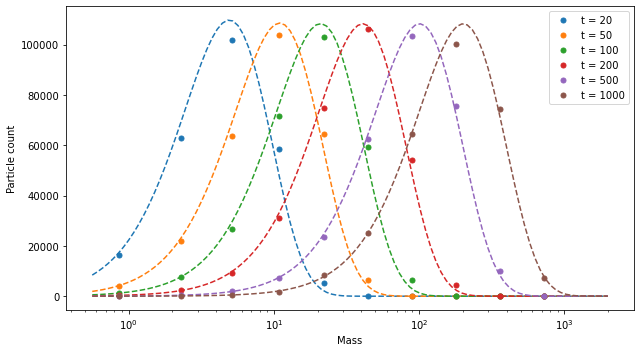

In [51]:
# Creat figure
fig = plt.figure(figsize = (9,5))

# Create some size bins for plotting histograms
# First, find smallest and largest particle size
M_min = np.amin(M[M>0])
M_max = np.amax(M[M>0])
# Create some log-spaced bins, each bin double the size of the last
# and make sure they match up with integer multiples of m0
# (meaning the bin-edges should not be integers)
factor = 2
istop = int(np.log(M_max/m0)/np.log(factor))+1
bins = np.array([m0*(factor**i-0.5) for i in range(istop)])
# Find midpoints of the bins (on log scale)
mids = np.sqrt(bins[1:]*bins[:-1])

# List of masses for which to plot the analytical solution
ms = np.logspace(np.log10(M_min)-0.25, np.log10(M_max)+0.25, 100)

# Plot a few different timesteps
Nt = M.shape[0]
for it in [2, 5, 10, 20, 50, 100]:
    # Get histogram of particle counts for output timestep it
    # using masking to get only valid particles (invalid particles have M = -999)
    h, _ = np.histogram(M[it,:][M[it,:]>0], bins=bins)
    # Plot particle counts times mass squared,
    # (see Figure is Wetherill)
    # and scaled by bin width to get density
    l, = plt.plot(mids, mids**2 * h / (bins[1:]-bins[:-1]), marker='.', lw=0, markersize=10, label = f't = {it*save_dt}')
    # Plot analytical solution for the same time (output timestep times time index)
    # and plotting for a larger number of masses, to get smooth curve
    plt.plot(ms, ms**2 * nk(ms, save_dt*it, Np), '--', c = l.get_color())


plt.xscale('log')
plt.xlabel('Mass')
plt.ylabel('Particle count')
plt.legend()
plt.tight_layout()
plt.savefig('analytical_comparison_constant_kernel.png')

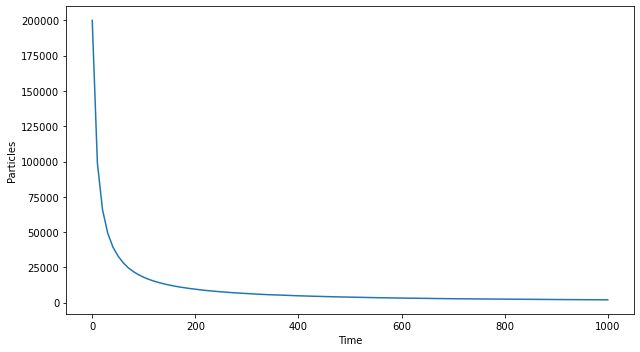

In [47]:
# Creat figure
fig = plt.figure(figsize = (9,5))

# Plot number of particles as a function of time
t = np.linspace(0, Tmax, M.shape[0])
plt.plot(t, np.sum(M>0, axis=1))
plt.xlabel('Time')
plt.ylabel('Particles')
plt.tight_layout()
plt.savefig('particle_count_constant_kernel.png')